In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
from utils import load_jester

# import jtplot
from jupyterthemes import jtplot

# you can select an alternative theme's plot style by name
# oceans16 | grade3 | chesterish | onedork | monokai | solarizedl
jtplot.style('onedork')

# set "context" (paper, notebook, talk, or poster)
# & font scale (scalar applied to labels, legend, etc.)
jtplot.style('grade3', context='paper', fscale=1.4)

# turn on X- and Y-axis tick marks (default=False)
# and turn off the axis grid lines (default=True)
jtplot.style(ticks=True, grid=False)

# set the default figure size
# x (length), y (height)
jtplot.figsize(x=8., y=7.)

# or just adjust the aspect ratio
# new_length = length * aspect
#jtplot.figsize(aspect=0.8)

In [6]:
batch_size = 3000
train_iter, val_iter, test_iter, text_field = load_jester(ratings_path='jester_ratings.dat.gz', jokes_path='jester_items.clean.dat.gz', subsample_rate=1.0, batch_size=batch_size, \
                                                          gpu=False, repeat=False, shuffle=True)

Loading Data, this might take several minutes
0 lines read
100000 lines read
200000 lines read
300000 lines read
400000 lines read
500000 lines read
600000 lines read
700000 lines read
800000 lines read
900000 lines read
1000000 lines read
1100000 lines read
1200000 lines read
1300000 lines read
1400000 lines read
1500000 lines read
1600000 lines read
1700000 lines read
Data Loaded


In [7]:
highest_user_id = 0
highest_joke_id = 0
train_users = []
train_jokes = []
train_ratings = []

user_jokes = dict()
joke_users = dict()
user_ratings = dict()
joke_ratings = dict()

for batch in train_iter:
    users = batch.users.data.numpy()-1
    jokes = batch.jokes.data.numpy()-1
    ratings = batch.ratings.data.numpy()
    
    train_users += users.tolist()
    train_jokes += jokes.tolist()
    train_ratings += ratings.tolist()
        
    for i in range(len(users)):
        if users[i] not in user_jokes.keys():
            user_jokes[users[i]] = []
            user_ratings[users[i]] = []
            
        if jokes[i] not in joke_users.keys():
            joke_users[jokes[i]] = []
            joke_ratings[jokes[i]] = [] 
        
        user_jokes[users[i]].append(jokes[i])
        joke_users[jokes[i]].append(users[i])
        user_ratings[users[i]].append(ratings[i])
        joke_ratings[jokes[i]].append(ratings[i])
    
    if np.max(users) > highest_user_id:
        highest_user_id = np.max(users)
        
    if np.max(jokes) > highest_joke_id:
        highest_joke_id = np.max(jokes)
        


test_users = []
test_jokes = []
test_ratings = []
for batch in test_iter:
    users = batch.users.data.numpy()-1
    jokes = batch.jokes.data.numpy()-1
    ratings = batch.ratings.data.numpy()
    
    for i in range(len(users)):
        if users[i] in user_jokes.keys() and jokes[i] in joke_users.keys():
            test_users.append(users[i])
            test_jokes.append(jokes[i])
            test_ratings.append(ratings[i])
            
train_users = torch.from_numpy(np.array(train_users)).long()
train_jokes = torch.from_numpy(np.array(train_jokes)).long()
train_ratings = torch.from_numpy(np.array(train_ratings)).double()
train_data_size = len(train_users)

test_users = torch.from_numpy(np.array(test_users)).long()
test_jokes = torch.from_numpy(np.array(test_jokes)).long()
test_ratings = torch.from_numpy(np.array(test_ratings)).double()
test_data_size = len(test_users)

### Problem 2

In [ ]:
def neg_variational_objective(user_lambda_mu, joke_lambda_mu, user_lambda_var, joke_lambda_var, sigmaU2, sigmaV2, sigmaE2, K, users, jokes, ratings, num_batches):
    
    first_term = (-0.5 * torch.sum(torch.log(sigmaU2/user_lambda_var) + (user_lambda_var + user_lambda_mu**2)/sigmaU2))/num_batches
    second_term = (-0.5 * torch.sum(torch.log(sigmaV2/joke_lambda_var) + (joke_lambda_var + joke_lambda_mu**2)/sigmaV2))/num_batches
    third_term = 0.5 * ((sigmaE2)**(-1)) * torch.sum((ratings - torch.sum((Variable(torch.normal(means = torch.zeros((len(users), K)), std = 1.0)) *\
                                                                                   user_lambda_var[users] + user_lambda_mu[users]) *\
    (Variable(torch.normal(means = torch.zeros((len(jokes), K)), std = 1.0)) * joke_lambda_var[jokes] + joke_lambda_mu[jokes]), dim = 1)) ** 2)
    
    return first_term + second_term + third_term

In [153]:
def loglik__sqError__lowerBound_varInf(user_lambda_mu, joke_lambda_mu, user_lambda_var, joke_lambda_var, sigmaU2, sigmaV2, sigmaE2, K, users, jokes, ratings, num_batches):
    
    first_term = (-0.5 * torch.sum(torch.log(sigmaU2/user_lambda_var) + (user_lambda_var + user_lambda_mu**2)/sigmaU2))/num_batches
    second_term = (-0.5 * torch.sum(torch.log(sigmaV2/joke_lambda_var) + (joke_lambda_var + joke_lambda_mu**2)/sigmaV2))/num_batches
    
    sum_squared_diff = torch.sum((ratings - torch.sum(user_lambda_mu[users] * joke_lambda_mu[jokes], dim = 1)) ** 2)
    loglik = -0.5 * ((sigmaE2)**(-1)) * sum_squared_diff
    
    return loglik.data.numpy()[0], sum_squared_diff.data.numpy()[0], (first_term + second_term).data.numpy()[0]

In [204]:
sigmaU2 = 5.0
sigmaV2 = 5.0
sigmaE2 = 1.0
epochs = 10
lrs = [0.0025, 0.0018, 0.0015, 0.001, 0.00095, 0.0009, 0.00085, 0.0008, 0.00075, 0.0007]
train_log_liks_by_K = [[] for i in range(10)]
test_log_liks_by_K = [[] for i in range(10)]
train_rmse_by_K = [[] for i in range(10)]
test_rmse_by_K = [[] for i in range(10)]
train_lower_by_K = [[] for i in range(10)]
test_lower_by_K = [[] for i in range(10)]

for K in range(1, 11):
    
    user_lambda_mu = Variable(torch.rand(int(highest_user_id+1), K), requires_grad = True)
    joke_lambda_mu = Variable(torch.rand(int(highest_joke_id+1), K), requires_grad = True)

    user_lambda_var = Variable(0.00000000000000000000000001 * torch.rand(int(highest_user_id+1), K), requires_grad = True)
    joke_lambda_var = Variable(0.00000000000000000000000001 * torch.rand(int(highest_joke_id+1), K), requires_grad = True)

    optimizer = torch.optim.Adam([user_lambda_mu, joke_lambda_mu, user_lambda_var, joke_lambda_var], lr = lrs[K-1])
    
    for epoch in range(epochs):

        for batch in train_iter:

            users = batch.users-1
            jokes = batch.jokes-1
            ratings = batch.ratings.float()

            optimizer.zero_grad()
            loss = neg_variational_objective(user_lambda_mu, joke_lambda_mu, user_lambda_var, joke_lambda_var, sigmaU2, sigmaV2, sigmaE2, K, users, jokes, ratings, len(train_iter))
            loss.backward()
            optimizer.step()    

            
        epoch_train_loglik = 0.0
        epoch_train_rmse = 0.0
        epoch_train_lower_bound = 0.0
        for batch in train_iter:
            users = batch.users-1
            jokes = batch.jokes-1
            ratings = batch.ratings.float()

            train_loglik__sqError__lowerBound = loglik__sqError__lowerBound_varInf(user_lambda_mu, joke_lambda_mu, user_lambda_var, joke_lambda_var, sigmaU2, sigmaV2, sigmaE2, K, users, jokes, ratings, len(train_iter))

            epoch_train_loglik += train_loglik__sqError__lowerBound[0]
            epoch_train_rmse += train_loglik__sqError__lowerBound[1]/train_data_size
            epoch_train_lower_bound += train_loglik__sqError__lowerBound[2]/train_data_size
        
        epoch_avg_train_loglik = epoch_train_loglik/train_data_size
        epoch_train_rmse = (epoch_train_rmse)**0.5
        epoch_train_avg_lower_bound = epoch_train_lower_bound + epoch_avg_train_loglik
        
        epoch_test_loglik = 0.0
        epoch_test_rmse = 0.0
        epoch_test_lower_bound = 0.0
        for batch in test_iter:
            users = batch.users-1
            jokes = batch.jokes-1
            ratings = batch.ratings.float()

            test_loglik__sqError__lowerBound = loglik__sqError__lowerBound_varInf(user_lambda_mu, joke_lambda_mu, user_lambda_var, joke_lambda_var, sigmaU2, sigmaV2, sigmaE2, K, users, jokes, ratings, len(test_iter))

            epoch_test_loglik += test_loglik__sqError__lowerBound[0]
            epoch_test_rmse += test_loglik__sqError__lowerBound[1]/test_data_size
            epoch_test_lower_bound += test_loglik__sqError__lowerBound[2]/train_data_size
        
        epoch_avg_test_loglik = epoch_test_loglik/test_data_size
        epoch_test_rmse = epoch_test_rmse**0.5
        epoch_test_avg_lower_bound = epoch_test_lower_bound + epoch_avg_test_loglik

        print('Epoch ' + str(epoch+1) + '   K = ' + str(K) + '   Train average log-likelihood: ' + str(epoch_avg_train_loglik) + '   Test average log-likelihood: ' + str(epoch_avg_test_loglik) +\
              '   Train RMSE: ' + str(epoch_train_rmse) + '   Test RMSE: ' + str(epoch_test_rmse) + '\nTrain average log marginal likelihood lower bound: ' + str(epoch_train_avg_lower_bound) +\
              '   Test average log marginal likelihood lower bound: ' + str(epoch_test_avg_lower_bound))
        
        train_log_liks_by_K[K-1].append(epoch_avg_train_loglik)
        test_log_liks_by_K[K-1].append(epoch_avg_test_loglik)
        train_rmse_by_K[K-1].append(epoch_train_rmse)
        test_rmse_by_K[K-1].append(epoch_test_rmse)
        train_lower_by_K[K-1].append(epoch_train_avg_lower_bound)
        test_lower_by_K[K-1].append(epoch_test_avg_lower_bound)
        
        #np.save('train_log_liks_var_inf.npy', train_log_liks_by_K)
        #np.save('test_log_liks_var_inf.npy', test_log_liks_by_K)
        #np.save('train_rmse_var_inf.npy', train_rmse_by_K)
        #np.save('test_rmse_var_inf.npy', test_rmse_by_K)
        #np.save('train_lower_var_inf.npy', train_lower_by_K)
        #np.save('test_lower_var_inf.npy', test_lower_by_K)
    
    print()

Epoch 1   K = 1   Train average log-likelihood: -4.39620289384   Test average log-likelihood: -4.36532292657   Train RMSE: 2.96519911434   Test RMSE: 2.9547666326
Train average log marginal likelihood lower bound: -5.56148300876   Test average log marginal likelihood lower bound: -5.5306030415
Epoch 2   K = 1   Train average log-likelihood: -2.98401520496   Test average log-likelihood: -2.97317702419   Train RMSE: 2.44295526155   Test RMSE: 2.43851472179
Train average log marginal likelihood lower bound: -4.1553038415   Test average log marginal likelihood lower bound: -4.14446571503
Epoch 3   K = 1   Train average log-likelihood: -1.88933950195   Test average log-likelihood: -1.90431697515   Train RMSE: 1.9438824563   Test RMSE: 1.95157217399
Train average log marginal likelihood lower bound: -3.06907657833   Test average log marginal likelihood lower bound: -3.08405407869
Epoch 4   K = 1   Train average log-likelihood: -1.25120634866   Test average log-likelihood: -1.29662098951   Tr

Train average log marginal likelihood lower bound: -4.11585156258   Test average log marginal likelihood lower bound: -4.27318646648
Epoch 9   K = 3   Train average log-likelihood: -0.530275410811   Test average log-likelihood: -0.715751840287   Train RMSE: 1.02983048198   Test RMSE: 1.19645462955
Train average log marginal likelihood lower bound: -4.11993640702   Test average log marginal likelihood lower bound: -4.30541272788
Epoch 10   K = 3   Train average log-likelihood: -0.521816162731   Test average log-likelihood: -0.742116962323   Train RMSE: 1.02158324451   Test RMSE: 1.21829139562
Train average log marginal likelihood lower bound: -4.13077950001   Test average log marginal likelihood lower bound: -4.35108040822

Epoch 1   K = 4   Train average log-likelihood: -2.5983925048   Test average log-likelihood: -2.56144356365   Train RMSE: 2.27964580793   Test RMSE: 2.26337958091
Train average log marginal likelihood lower bound: -7.24848612745   Test average log marginal likelihood

Train average log marginal likelihood lower bound: -7.57935466809   Test average log marginal likelihood lower bound: -7.66340479456
Epoch 7   K = 6   Train average log-likelihood: -0.545891438704   Test average log-likelihood: -0.651813189116   Train RMSE: 1.04488414545   Test RMSE: 1.14176458967
Train average log marginal likelihood lower bound: -7.56704762417   Test average log marginal likelihood lower bound: -7.67296959181
Epoch 8   K = 6   Train average log-likelihood: -0.531933590321   Test average log-likelihood: -0.65735396975   Train RMSE: 1.03143937323   Test RMSE: 1.14660714262
Train average log marginal likelihood lower bound: -7.56503350662   Test average log marginal likelihood lower bound: -7.69045366883
Epoch 9   K = 6   Train average log-likelihood: -0.523018946956   Test average log-likelihood: -0.6723856548   Train RMSE: 1.02275993953   Test RMSE: 1.15964275085
Train average log marginal likelihood lower bound: -7.56909809104   Test average log marginal likelihood l

Train average log marginal likelihood lower bound: -11.0622310257   Test average log marginal likelihood lower bound: -11.116328453
Epoch 5   K = 9   Train average log-likelihood: -0.554689027377   Test average log-likelihood: -0.625654828351   Train RMSE: 1.05327017178   Test RMSE: 1.1186195317
Train average log marginal likelihood lower bound: -11.0407809586   Test average log marginal likelihood lower bound: -11.1117465423
Epoch 6   K = 9   Train average log-likelihood: -0.537258947752   Test average log-likelihood: -0.627175377251   Train RMSE: 1.03658955016   Test RMSE: 1.11997801519
Train average log marginal likelihood lower bound: -11.0334425756   Test average log marginal likelihood lower bound: -11.1233592223
Epoch 7   K = 9   Train average log-likelihood: -0.526212117767   Test average log-likelihood: -0.637548886346   Train RMSE: 1.02587730043   Test RMSE: 1.12920227271
Train average log marginal likelihood lower bound: -11.0336741257   Test average log marginal likelihood 

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


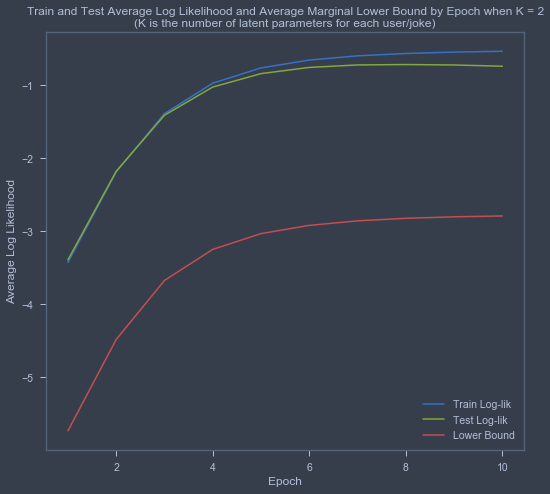

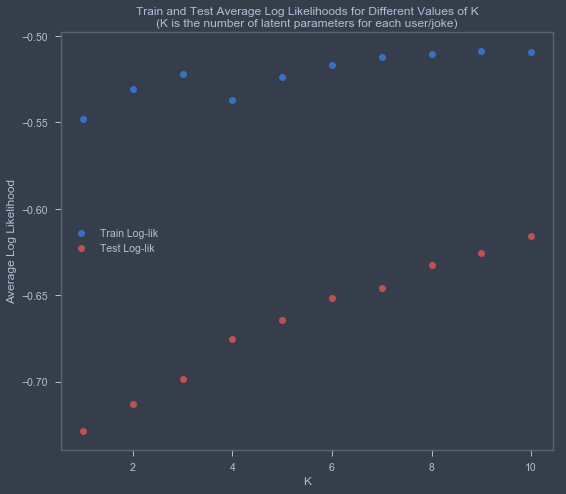

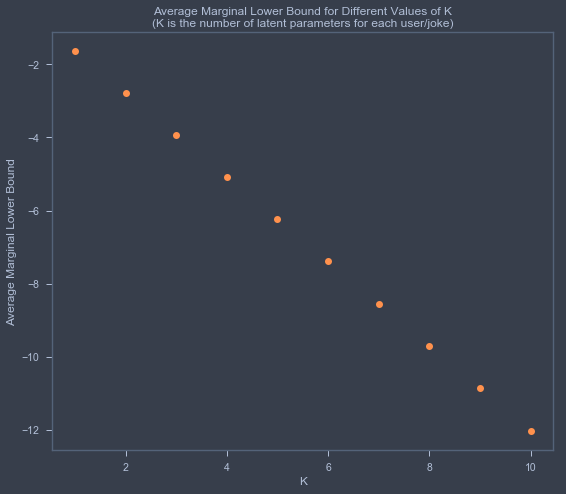

In [15]:
sigmaU2 = 5.0
sigmaV2 = 5.0
sigmaE2 = 1.0
epochs = 10
train_log_liks_by_K_var_inf = np.load('train_log_liks_var_inf.npy')
test_log_liks_by_K_var_inf = np.load('test_log_liks_var_inf.npy')
#train_rmse_by_K_var_inf = np.load('train_rmse_var_inf.npy')
#test_rmse_by_K_var_inf = np.load('test_rmse_var_inf.npy')
train_lower_by_K_var_inf = np.load('train_lower_var_inf.npy')
#test_lower_by_K_var_inf = np.load('test_lower_var_inf.npy')

plt.plot(np.arange(epochs)+1, train_log_liks_by_K_var_inf[1])
plt.plot(np.arange(epochs)+1, test_log_liks_by_K_var_inf[1])
plt.plot(np.arange(epochs)+1, train_lower_by_K_var_inf[1])
plt.xlabel('Epoch')
plt.ylabel('Average Log Likelihood')
plt.title('Train and Test Average Log Likelihood and Average Marginal Lower Bound by Epoch when K = 2\n(K is the number of latent parameters for each user/joke)')
plt.legend(loc = 'lower right', labels = ['Train Log-lik', 'Test Log-lik', 'Lower Bound'])
#plt.ylim([-1.0, -0.4])
plt.show()

#plt.plot(np.arange(epochs)+1, train_rmse_by_K_var_inf[1])
#plt.plot(np.arange(epochs)+1, test_rmse_by_K_var_inf[1])
#plt.xlabel('Epoch')
#plt.ylabel('RMSE')
#plt.title('Train and Test RMSE by Epoch when K = 2\n(K is the number of latent parameters for each user/joke)')
#plt.legend(loc = 'upper right', labels = ['Train', 'Test'])
#plt.ylim([1.0, 1.5])
#plt.show()

plt.plot(np.arange(1, 11), [np.max(train_log_liks_by_K_var_inf[i]) for i in range(len(train_log_liks_by_K_var_inf))], 'bo')
plt.plot(np.arange(1, 11), [np.max(test_log_liks_by_K_var_inf[i]) for i in range(len(test_log_liks_by_K_var_inf))], 'ro')
plt.xlabel('K')
plt.ylabel('Average Log Likelihood')
plt.title('Train and Test Average Log Likelihoods for Different Values of K\n(K is the number of latent parameters for each user/joke)')
plt.legend(loc = 'center left', labels = ['Train Log-lik', 'Test Log-lik'])
plt.show()


plt.plot(np.arange(1, 11), [np.max(train_lower_by_K_var_inf[i]) for i in range(len(train_lower_by_K_var_inf))], 'yo')
plt.xlabel('K')
plt.ylabel('Average Marginal Lower Bound')
plt.title('Average Marginal Lower Bound for Different Values of K\n(K is the number of latent parameters for each user/joke)')
plt.show()

### Problem 3

In [309]:
def avg_log_likelihood_gibbs(sigmaE2, U, V, users, jokes, ratings):
    
    preds = torch.mm(U, torch.transpose(V, 1, 0))[users, jokes]
    sum_squared_diff = torch.sum((ratings - preds)**2)
    
    multiplier = 1/(2*sigmaE2)
    constant = -len(users) * torch.log((2 * np.pi * sigmaE2 * torch.ones(1))**0.5)
        
    log_lik = constant - multiplier * sum_squared_diff
        
    return log_lik.numpy()[0]/len(users)

In [310]:
def rmse_gibbs(sigmaE2, U, V, users, jokes, ratings):
    
    preds = torch.mm(U, torch.transpose(V, 1, 0))[users, jokes]
    sum_squared_diff = torch.sum((ratings - preds)**2)

    return (sum_squared_diff/len(users))**0.5

In [350]:
sigmaU2 = 5.0
sigmaV2 = 5.0
sigmaE2 = 1.0
iterations = 100
train_log_liks_by_K = []
test_log_liks_by_K = []
train_rmse_by_K = []
test_rmse_by_K = []

for K in range(1, 11):
    U = torch.from_numpy(np.random.multivariate_normal(np.zeros(K), sigmaU2 * np.identity(K), highest_user_id+1))
    V = torch.from_numpy(np.random.multivariate_normal(np.zeros(K), sigmaV2 * np.identity(K), highest_joke_id+1))
    train_log_liks_by_K.append([])
    test_log_liks_by_K.append([])
    train_rmse_by_K.append([])
    test_rmse_by_K.append([])
        
    train_avg_log_lik = avg_log_likelihood_gibbs(sigmaE2, U, V, train_users, train_jokes, train_ratings)
    test_avg_log_lik = avg_log_likelihood_gibbs(sigmaE2, U, V, test_users, test_jokes, test_ratings)
    train_rmse = rmse_gibbs(sigmaE2, U, V, train_users, train_jokes, train_ratings)
    test_rmse = rmse_gibbs(sigmaE2, U, V, test_users, test_jokes, test_ratings)
    
    train_log_liks_by_K[K-1].append(train_avg_log_lik)
    test_log_liks_by_K[K-1].append(test_avg_log_lik)
    train_rmse_by_K[K-1].append(train_rmse)
    test_rmse_by_K[K-1].append(test_rmse)
    
    print('K: ' + str(K) + '   Iteration: 0' + '   Train average log-likelihood: ' + str(train_avg_log_lik) + '   Test average log-likelihood: ' + str(test_avg_log_lik) +\
          '   Train RMSE: ' + str(train_rmse) + '   Test RMSE: ' + str(test_rmse)) 

    for iteration in range(iterations):
        
        for i in user_jokes.keys(): # go through each user
            jokes_i = torch.from_numpy(np.array(user_jokes[i])) # jokes user i has rated in training data
            V_i = V[jokes_i, :] # latent parameters associated with jokes user i has rated in training data
            R_i = torch.from_numpy(np.array(user_ratings[i])).double() # ratings for jokes rated by user i in training data
            psi_i = torch.inverse((torch.eye(K) * (1/sigmaU2)).double() + torch.mm(torch.transpose(V_i, 1, 0), V_i)) # variance-covariance matrix of posterior of user i latent parameters
            theta_i = ((1/sigmaE2) * torch.mm(torch.mm(psi_i, torch.transpose(V_i, 1, 0)), R_i.unsqueeze(1))) # mean of posterior of user i latent parameters
            U[i] = torch.from_numpy(np.random.multivariate_normal(theta_i.numpy().flatten(), psi_i.numpy(), 1)) # sample from posterior of user i latent parameters and use as new latent parameters for user i
                
                
        for j in joke_users.keys(): # go through each joke
            users_j = torch.from_numpy(np.array(joke_users[j])) # users that have rated joke j in training data
            U_j = U[users_j, :] # latent parameters associated with users that have rated joke j in training data
            R_j = torch.from_numpy(np.array(joke_ratings[j])).double() # ratings made by users who rated joke j in training data
            beta_j = torch.inverse((torch.eye(K) * (1/sigmaU2)).double() + torch.mm(torch.transpose(U_j, 1, 0), U_j)) # variance-covariance matrix of posterior of joke j latent parameters
            alpha_j = ((1/sigmaE2) * torch.mm(torch.mm(beta_j, torch.transpose(U_j, 1, 0)), R_j.unsqueeze(1))) # mean of posterior of joke j latent parameters
            V[j] = torch.from_numpy(np.random.multivariate_normal(alpha_j.numpy().flatten(), beta_j.numpy(), 1)) # sample from posterior of joke j latent parameters and use as new latent parameters for joke j
                
        train_avg_log_lik = avg_log_likelihood_gibbs(sigmaE2, U, V, train_users, train_jokes, train_ratings)
        test_avg_log_lik = avg_log_likelihood_gibbs(sigmaE2, U, V, test_users, test_jokes, test_ratings)
        train_rmse = rmse_gibbs(sigmaE2, U, V, train_users, train_jokes, train_ratings)
        test_rmse = rmse_gibbs(sigmaE2, U, V, test_users, test_jokes, test_ratings)
        
        train_log_liks_by_K[K-1].append(train_avg_log_lik)
        test_log_liks_by_K[K-1].append(test_avg_log_lik)
        train_rmse_by_K[K-1].append(train_rmse)
        test_rmse_by_K[K-1].append(test_rmse)
        
        print('K: ' + str(K) + '   Iteration: ' + str(iteration+1) + '   Train average log-likelihood: ' + str(train_avg_log_lik) + '   Test average log-likelihood: ' + str(test_avg_log_lik) +\
              '   Train RMSE: ' + str(train_rmse) + '   Test RMSE: ' + str(test_rmse))
        
        #np.save('train_log_liks_gibbs.npy', train_log_liks_by_K)
        #np.save('test_log_liks_gibbs.npy', test_log_liks_by_K)
        #np.save('train_rmse_gibbs.npy', train_rmse_by_K)
        #np.save('test_rmse_gibbs.npy', test_rmse_by_K)
        
    print()

K: 1   Iteration: 0   Train average log-likelihood: -17.5151119851   Test average log-likelihood: -17.4814331138   Train RMSE: 5.761280120900984   Test RMSE: 5.755431159493231
K: 1   Iteration: 1   Train average log-likelihood: -3.83946922544   Test average log-likelihood: -3.99799408784   Train RMSE: 2.4168287180781   Test RMSE: 2.4815541197752014
K: 1   Iteration: 2   Train average log-likelihood: -1.6272312313   Test average log-likelihood: -1.68359031218   Train RMSE: 1.1902039642904443   Test RMSE: 1.2366501815812827
K: 1   Iteration: 3   Train average log-likelihood: -1.49239361194   Test average log-likelihood: -1.54064278794   Train RMSE: 1.0709389188336635   Test RMSE: 1.1150823493628261
K: 1   Iteration: 4   Train average log-likelihood: -1.45215180048   Test average log-likelihood: -1.49313689264   Train RMSE: 1.0326793036123616   Test RMSE: 1.0716327748347214
K: 1   Iteration: 5   Train average log-likelihood: -1.4433459129   Test average log-likelihood: -1.48064296981   Tr

K: 1   Iteration: 91   Train average log-likelihood: -1.44118817502   Test average log-likelihood: -1.47597895788   Train RMSE: 1.0220075470784455   Test RMSE: 1.0555003424380152
K: 1   Iteration: 92   Train average log-likelihood: -1.44120526314   Test average log-likelihood: -1.47765029259   Train RMSE: 1.0220242151725032   Test RMSE: 1.0570825708076586
K: 1   Iteration: 93   Train average log-likelihood: -1.44100512933   Test average log-likelihood: -1.48111062415   Train RMSE: 1.0218284138611773   Test RMSE: 1.0603509462773444
K: 1   Iteration: 94   Train average log-likelihood: -1.44118788539   Test average log-likelihood: -1.47809554565   Train RMSE: 1.022007168246472   Test RMSE: 1.057503671568561
K: 1   Iteration: 95   Train average log-likelihood: -1.44126391306   Test average log-likelihood: -1.47907920558   Train RMSE: 1.0220816115084004   Test RMSE: 1.058433502707035
K: 1   Iteration: 96   Train average log-likelihood: -1.44135905627   Test average log-likelihood: -1.480210

K: 2   Iteration: 80   Train average log-likelihood: -1.40888930081   Test average log-likelihood: -1.47102406207   Train RMSE: 0.989899844398333   Test RMSE: 1.0507954552192125
K: 2   Iteration: 81   Train average log-likelihood: -1.40876606356   Test average log-likelihood: -1.47024356618   Train RMSE: 0.9897752422782993   Test RMSE: 1.0500525251414077
K: 2   Iteration: 82   Train average log-likelihood: -1.40923381479   Test average log-likelihood: -1.46786270991   Train RMSE: 0.990247724577234   Test RMSE: 1.0477826333157036
K: 2   Iteration: 83   Train average log-likelihood: -1.40881370757   Test average log-likelihood: -1.47026641104   Train RMSE: 0.989823495232779   Test RMSE: 1.0500742541392791
K: 2   Iteration: 84   Train average log-likelihood: -1.4089734381   Test average log-likelihood: -1.47144414142   Train RMSE: 0.9899847957282014   Test RMSE: 1.0511951347928261
K: 2   Iteration: 85   Train average log-likelihood: -1.40897213477   Test average log-likelihood: -1.4702750

K: 3   Iteration: 70   Train average log-likelihood: -1.39297316006   Test average log-likelihood: -1.46663230326   Train RMSE: 0.9736885507757493   Test RMSE: 1.0466076147616659
K: 3   Iteration: 71   Train average log-likelihood: -1.39330261332   Test average log-likelihood: -1.46230131622   Train RMSE: 0.9740268545712287   Test RMSE: 1.0424612877310169
K: 3   Iteration: 72   Train average log-likelihood: -1.39350752602   Test average log-likelihood: -1.46752325297   Train RMSE: 0.9742371789642769   Test RMSE: 1.047458582004751
K: 3   Iteration: 73   Train average log-likelihood: -1.39304947736   Test average log-likelihood: -1.4717393503   Train RMSE: 0.9737668222761074   Test RMSE: 1.051475950319996
K: 3   Iteration: 74   Train average log-likelihood: -1.39325945857   Test average log-likelihood: -1.46922186843   Train RMSE: 0.9739824169767716   Test RMSE: 1.0490790101192111
K: 3   Iteration: 75   Train average log-likelihood: -1.39318560311   Test average log-likelihood: -1.466316

K: 4   Iteration: 59   Train average log-likelihood: -1.38088345609   Test average log-likelihood: -1.46285924104   Train RMSE: 0.9611919327443024   Test RMSE: 1.042996426931477
K: 4   Iteration: 60   Train average log-likelihood: -1.38118872531   Test average log-likelihood: -1.46522069026   Train RMSE: 0.9615094533573432   Test RMSE: 1.0452580305637904
K: 4   Iteration: 61   Train average log-likelihood: -1.38118278791   Test average log-likelihood: -1.46680419423   Train RMSE: 0.9615032823484142   Test RMSE: 1.0467718202189138
K: 4   Iteration: 62   Train average log-likelihood: -1.38123694858   Test average log-likelihood: -1.46399649387   Train RMSE: 0.9615596200400681   Test RMSE: 1.0440861869501705
K: 4   Iteration: 63   Train average log-likelihood: -1.38107185991   Test average log-likelihood: -1.46515692426   Train RMSE: 0.9613878688405489   Test RMSE: 1.0451970532270674
K: 4   Iteration: 64   Train average log-likelihood: -1.38148400233   Test average log-likelihood: -1.4615

K: 5   Iteration: 48   Train average log-likelihood: -1.37035340561   Test average log-likelihood: -1.4651847595   Train RMSE: 0.9501735924440422   Test RMSE: 1.045223692640435
K: 5   Iteration: 49   Train average log-likelihood: -1.37066663963   Test average log-likelihood: -1.46475769362   Train RMSE: 0.9505031992402916   Test RMSE: 1.0448149942311296
K: 5   Iteration: 50   Train average log-likelihood: -1.37033979303   Test average log-likelihood: -1.46071792315   Train RMSE: 0.9501592807485563   Test RMSE: 1.0409413608760838
K: 5   Iteration: 51   Train average log-likelihood: -1.37057859234   Test average log-likelihood: -1.46444374308   Train RMSE: 0.9504106113024771   Test RMSE: 1.0445144806961921
K: 5   Iteration: 52   Train average log-likelihood: -1.37051791502   Test average log-likelihood: -1.46717858385   Train RMSE: 0.9503466654342018   Test RMSE: 1.0471294608243773
K: 5   Iteration: 53   Train average log-likelihood: -1.37036310819   Test average log-likelihood: -1.47145

K: 6   Iteration: 37   Train average log-likelihood: -1.36361300899   Test average log-likelihood: -1.46711759028   Train RMSE: 0.9430530330691776   Test RMSE: 1.04707126480696
K: 6   Iteration: 38   Train average log-likelihood: -1.36370931071   Test average log-likelihood: -1.47037619947   Train RMSE: 0.9431551292860548   Test RMSE: 1.0501787761235757
K: 6   Iteration: 39   Train average log-likelihood: -1.36345096142   Test average log-likelihood: -1.46524675115   Train RMSE: 0.9428811310553341   Test RMSE: 1.0452829416331415
K: 6   Iteration: 40   Train average log-likelihood: -1.36399169923   Test average log-likelihood: -1.46347438891   Train RMSE: 0.9434545272611965   Test RMSE: 1.0435859723655714
K: 6   Iteration: 41   Train average log-likelihood: -1.36420616968   Test average log-likelihood: -1.47192654511   Train RMSE: 0.9436817479589943   Test RMSE: 1.0516539756478902
K: 6   Iteration: 42   Train average log-likelihood: -1.3639013349   Test average log-likelihood: -1.470598

K: 7   Iteration: 26   Train average log-likelihood: -1.35799507051   Test average log-likelihood: -1.48527881381   Train RMSE: 0.9370768734376608   Test RMSE: 1.064274719926739
K: 7   Iteration: 27   Train average log-likelihood: -1.35789123843   Test average log-likelihood: -1.48401635781   Train RMSE: 0.9369660531851927   Test RMSE: 1.063087757754005
K: 7   Iteration: 28   Train average log-likelihood: -1.35800665568   Test average log-likelihood: -1.47396339765   Train RMSE: 0.9370892190754208   Test RMSE: 1.0535890363429692
K: 7   Iteration: 29   Train average log-likelihood: -1.35837158853   Test average log-likelihood: -1.47818359819   Train RMSE: 0.9374787193130427   Test RMSE: 1.0575869354277254
K: 7   Iteration: 30   Train average log-likelihood: -1.35852422314   Test average log-likelihood: -1.47355097022   Train RMSE: 0.9376415277742599   Test RMSE: 1.0531974442967014
K: 7   Iteration: 31   Train average log-likelihood: -1.35834827338   Test average log-likelihood: -1.47829

K: 8   Iteration: 15   Train average log-likelihood: -1.35398138842   Test average log-likelihood: -1.49786988275   Train RMSE: 0.932783888043298   Test RMSE: 1.0760402743682147
K: 8   Iteration: 16   Train average log-likelihood: -1.35412388601   Test average log-likelihood: -1.50798150764   Train RMSE: 0.9329367396892487   Test RMSE: 1.0853966867398197
K: 8   Iteration: 17   Train average log-likelihood: -1.35399586989   Test average log-likelihood: -1.50810216401   Train RMSE: 0.9327993640793124   Test RMSE: 1.0855078447999795
K: 8   Iteration: 18   Train average log-likelihood: -1.35425856361   Test average log-likelihood: -1.49881761193   Train RMSE: 0.9330809556496426   Test RMSE: 1.0769206658620523
K: 8   Iteration: 19   Train average log-likelihood: -1.3544317619   Test average log-likelihood: -1.4932663099   Train RMSE: 0.9332665255875845   Test RMSE: 1.0717535295284075
K: 8   Iteration: 20   Train average log-likelihood: -1.35416211707   Test average log-likelihood: -1.488460

K: 9   Iteration: 4   Train average log-likelihood: -1.33529378543   Test average log-likelihood: -1.72318678316   Train RMSE: 0.912529720826273   Test RMSE: 1.2682652459067068
K: 9   Iteration: 5   Train average log-likelihood: -1.33235708969   Test average log-likelihood: -1.6184071496   Train RMSE: 0.9093058802541402   Test RMSE: 1.1827667730928837
K: 9   Iteration: 6   Train average log-likelihood: -1.33370907901   Test average log-likelihood: -1.56892051584   Train RMSE: 0.9107915388731004   Test RMSE: 1.1401597188329302
K: 9   Iteration: 7   Train average log-likelihood: -1.33682925487   Test average log-likelihood: -1.54043507711   Train RMSE: 0.9142108605909788   Test RMSE: 1.1148960471306413
K: 9   Iteration: 8   Train average log-likelihood: -1.34060182061   Test average log-likelihood: -1.53325136537   Train RMSE: 0.9183282245403669   Test RMSE: 1.1084339202942708
K: 9   Iteration: 9   Train average log-likelihood: -1.3434805905   Test average log-likelihood: -1.51777507878 

K: 9   Iteration: 94   Train average log-likelihood: -1.35229893214   Test average log-likelihood: -1.47777693742   Train RMSE: 0.9309785159293968   Test RMSE: 1.057202371854813
K: 9   Iteration: 95   Train average log-likelihood: -1.35191256672   Test average log-likelihood: -1.47668082753   Train RMSE: 0.9305632972901278   Test RMSE: 1.0561650705716064
K: 9   Iteration: 96   Train average log-likelihood: -1.35210806646   Test average log-likelihood: -1.4750997633   Train RMSE: 0.9307733583010105   Test RMSE: 1.0546670428032112
K: 9   Iteration: 97   Train average log-likelihood: -1.35234208689   Test average log-likelihood: -1.47420914629   Train RMSE: 0.9310247822841243   Test RMSE: 1.0538222507447994
K: 9   Iteration: 98   Train average log-likelihood: -1.35244157454   Test average log-likelihood: -1.47536125937   Train RMSE: 0.9311316152165279   Test RMSE: 1.0549148809123847
K: 9   Iteration: 99   Train average log-likelihood: -1.35235975428   Test average log-likelihood: -1.47746

K: 10   Iteration: 83   Train average log-likelihood: -1.34942783743   Test average log-likelihood: -1.47228685076   Train RMSE: 0.9278894460276144   Test RMSE: 1.051996557520151
K: 10   Iteration: 84   Train average log-likelihood: -1.34946273775   Test average log-likelihood: -1.47947976699   Train RMSE: 0.9279269922875005   Test RMSE: 1.0588118932959256
K: 10   Iteration: 85   Train average log-likelihood: -1.34918947256   Test average log-likelihood: -1.4783022584   Train RMSE: 0.9276324563587557   Test RMSE: 1.0576991551022397
K: 10   Iteration: 86   Train average log-likelihood: -1.34931430276   Test average log-likelihood: -1.47632451418   Train RMSE: 0.9277671029666554   Test RMSE: 1.0558276830346847
K: 10   Iteration: 87   Train average log-likelihood: -1.34946650293   Test average log-likelihood: -1.47519225173   Train RMSE: 0.9279310736838651   Test RMSE: 1.0547546604598579
K: 10   Iteration: 88   Train average log-likelihood: -1.34924754322   Test average log-likelihood: -1

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


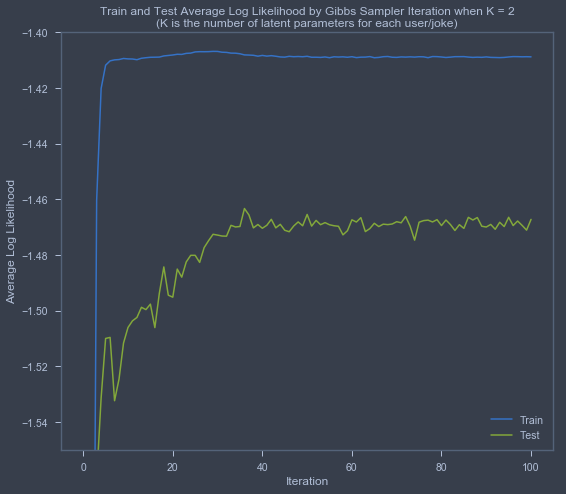

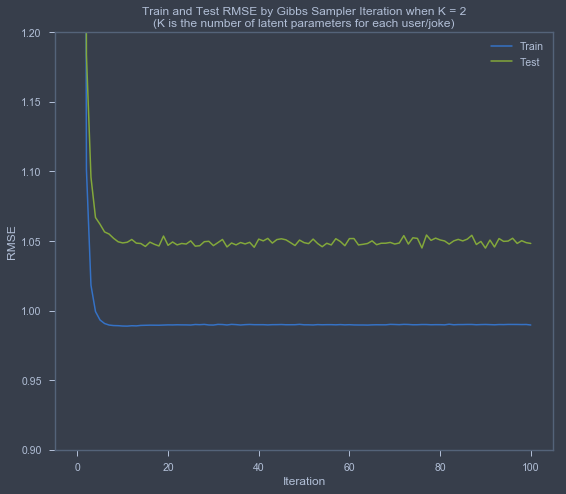

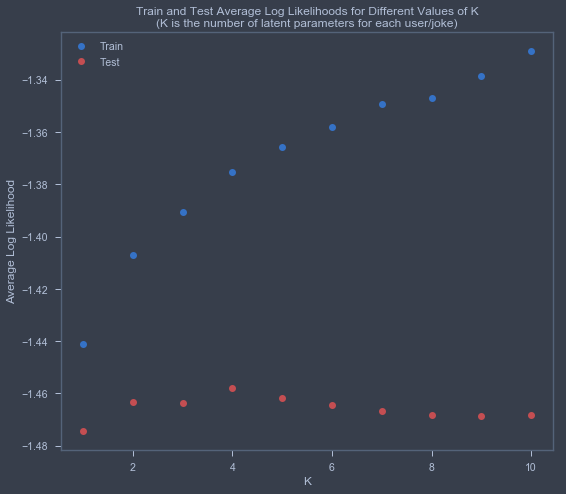

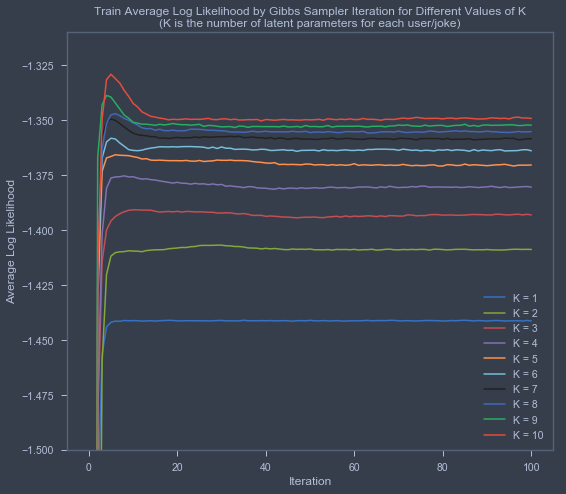

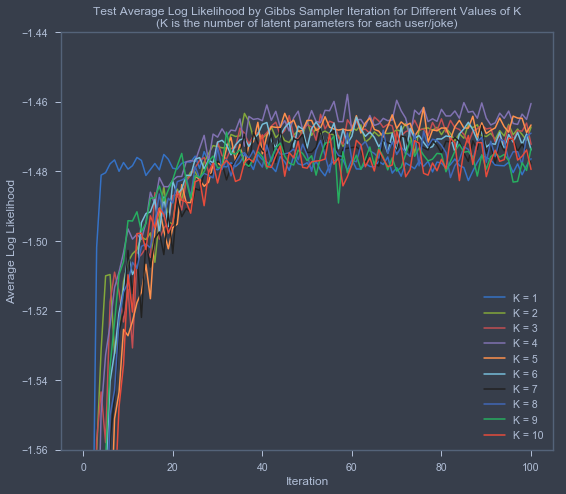

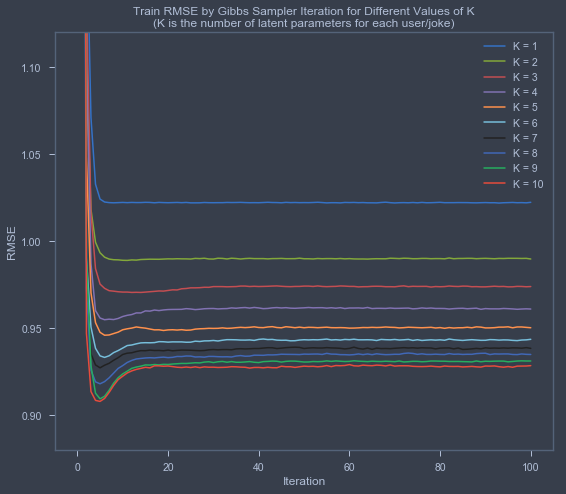

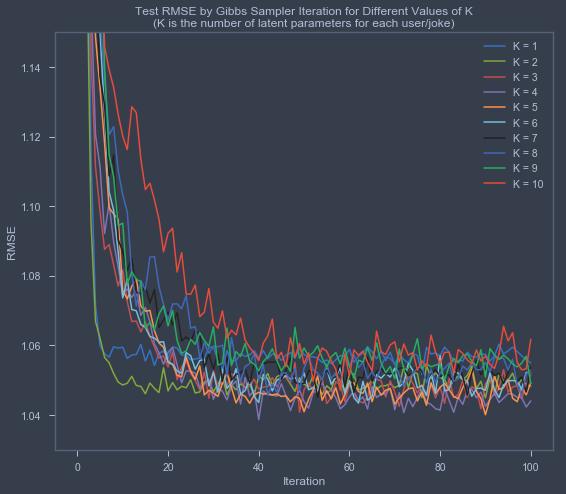

In [190]:
sigmaU2 = 5.0
sigmaV2 = 5.0
sigmaE2 = 1.0
iterations = 100
train_log_liks_by_K_gibbs = np.load('train_log_liks_gibbs_final.npy')
test_log_liks_by_K_gibbs = np.load('test_log_liks_gibbs_final.npy')
train_rmse_by_K_gibbs = np.load('train_rmse_gibbsV2.npy') # from different version of iterations
test_rmse_by_K_gibbs = np.load('test_rmse_gibbsV2.npy') # from different version of iterations

plt.plot(np.arange(iterations+1), train_log_liks_by_K_gibbs[1])
plt.plot(np.arange(iterations+1), test_log_liks_by_K_gibbs[1])
plt.xlabel('Iteration')
plt.ylabel('Average Log Likelihood')
plt.title('Train and Test Average Log Likelihood by Gibbs Sampler Iteration when K = 2\n(K is the number of latent parameters for each user/joke)')
plt.legend(loc = 'lower right', labels = ['Train', 'Test'])
plt.ylim([-1.55, -1.4])
plt.show()

plt.plot(np.arange(iterations+1), train_rmse_by_K_gibbs[1])
plt.plot(np.arange(iterations+1), test_rmse_by_K_gibbs[1])
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Train and Test RMSE by Gibbs Sampler Iteration when K = 2\n(K is the number of latent parameters for each user/joke)')
plt.legend(loc = 'upper right', labels = ['Train', 'Test'])
plt.ylim([0.9, 1.2])
plt.show()


plt.plot(np.arange(1, 11), [np.max(train_log_liks_by_K_gibbs[i]) for i in range(len(train_log_liks_by_K_gibbs))], 'bo')
plt.plot(np.arange(1, 11), [np.max(test_log_liks_by_K_gibbs[i]) for i in range(len(test_log_liks_by_K_gibbs))], 'ro')
plt.xlabel('K')
plt.ylabel('Average Log Likelihood')
plt.title('Train and Test Average Log Likelihoods for Different Values of K\n(K is the number of latent parameters for each user/joke)')
plt.legend(loc = 'upper left', labels = ['Train', 'Test'])
plt.show()

for i in range(1, 11):
    plt.plot(np.arange(iterations+1), train_log_liks_by_K_gibbs[i-1])
plt.xlabel('Iteration')
plt.ylabel('Average Log Likelihood')
plt.title('Train Average Log Likelihood by Gibbs Sampler Iteration for Different Values of K\n(K is the number of latent parameters for each user/joke)')
plt.legend(loc = 'lower right', labels = ['K = ' + str(i) for i in range(1, 11)])
plt.ylim([-1.50, -1.31])
plt.show()

for i in range(1, 11):
    plt.plot(np.arange(iterations+1), test_log_liks_by_K_gibbs[i-1])
plt.xlabel('Iteration')
plt.ylabel('Average Log Likelihood')
plt.title('Test Average Log Likelihood by Gibbs Sampler Iteration for Different Values of K\n(K is the number of latent parameters for each user/joke)')
plt.legend(loc = 'lower right', labels = ['K = ' + str(i) for i in range(1, 11)])
plt.ylim([-1.56, -1.44])
plt.show()


for i in range(1, 11):
    plt.plot(np.arange(iterations+1), train_rmse_by_K_gibbs[i-1])
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Train RMSE by Gibbs Sampler Iteration for Different Values of K\n(K is the number of latent parameters for each user/joke)')
plt.legend(loc = 'upper right', labels = ['K = ' + str(i) for i in range(1, 11)])
plt.ylim([0.88, 1.12])
plt.show()

for i in range(1, 11):
    plt.plot(np.arange(iterations+1), test_rmse_by_K_gibbs[i-1])
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Test RMSE by Gibbs Sampler Iteration for Different Values of K\n(K is the number of latent parameters for each user/joke)')
plt.legend(loc = 'upper right', labels = ['K = ' + str(i) for i in range(1, 11)])
plt.ylim([1.03, 1.15])
plt.show()